# QDrift

In [1]:
from trotter.hamsimtrotter import AlgorithmHamSimTrotter
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket.circuit import Circuit,Qubit,fresh_symbol

from utils.func import calculate_error

from tqdm import tqdm
import numpy as np

In [2]:
def gen_sys_param(n=4):
    global t_max
    global precision
    global initial_state_circ
    global t
    global hamiltonian
    global hamiltonian_drift
    global coeff
    global measurements
    global hamiltonian_test
    global h_test
    global coeff_test
    global Heisenberg
    global Heisenberg_d
    global Heisenberg_c
    global H3

    t_max=2
    precision = 10**(-4)
    initial_state_circ = Circuit(n)
    initial_state_circ.X(0)
    initial_state_circ.X(2)
    t = fresh_symbol("t")

    hamiltonian = QubitPauliOperator(
        {
            QubitPauliString([Qubit(0)], [Pauli.Z]): 0.1*t,
            QubitPauliString(
                [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
                [Pauli.Y, Pauli.Z, Pauli.X, Pauli.X],
            ): 0.4*t,
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): 0.2*t,
        }
    )

    H3 = QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(0)], [Pauli.X, Pauli.X]): t,
            
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t
        })


    Heisenberg = [
        QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(3), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(3), Qubit(0)], [Pauli.X, Pauli.X]): t,
            
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(3), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t,
            QubitPauliString([Qubit(3)],[Pauli.Z]): t
        }) ,
        QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(3), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(4), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(4), Qubit(0)], [Pauli.X, Pauli.X]): t,
            
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(4), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t,
            QubitPauliString([Qubit(3)],[Pauli.Z]): t,
            QubitPauliString([Qubit(4)],[Pauli.Z]): t
        }) ,
        QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(3), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(5), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(5), Qubit(0)], [Pauli.X, Pauli.X]): t,
            
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(5), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t,
            QubitPauliString([Qubit(3)],[Pauli.Z]): t,
            QubitPauliString([Qubit(4)],[Pauli.Z]): t,
            QubitPauliString([Qubit(5)],[Pauli.Z]): t
        }) ,
        QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(3), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(6), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(6), Qubit(0)], [Pauli.X, Pauli.X]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(6), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t,
            QubitPauliString([Qubit(3)],[Pauli.Z]): t,
            QubitPauliString([Qubit(4)],[Pauli.Z]): t,
            QubitPauliString([Qubit(5)],[Pauli.Z]): t,
            QubitPauliString([Qubit(6)],[Pauli.Z]): t
        }) ,
        QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(3), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(7), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(7), Qubit(0)], [Pauli.X, Pauli.X]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(7), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t,
            QubitPauliString([Qubit(3)],[Pauli.Z]): t,
            QubitPauliString([Qubit(4)],[Pauli.Z]): t,
            QubitPauliString([Qubit(5)],[Pauli.Z]): t,
            QubitPauliString([Qubit(6)],[Pauli.Z]): t,
            QubitPauliString([Qubit(7)],[Pauli.Z]): t
        }) ,
        QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(3), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(7), Qubit(8)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(8), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(7), Qubit(8)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(8), Qubit(0)], [Pauli.X, Pauli.X]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(7), Qubit(8)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(8), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t,
            QubitPauliString([Qubit(3)],[Pauli.Z]): t,
            QubitPauliString([Qubit(4)],[Pauli.Z]): t,
            QubitPauliString([Qubit(5)],[Pauli.Z]): t,
            QubitPauliString([Qubit(6)],[Pauli.Z]): t,
            QubitPauliString([Qubit(7)],[Pauli.Z]): t,
            QubitPauliString([Qubit(8)],[Pauli.Z]): t
        }) ,
        QubitPauliOperator(
        {
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(7), Qubit(8)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(8), Qubit(9)], [Pauli.Z, Pauli.Z]): t,
            QubitPauliString([Qubit(9), Qubit(0)], [Pauli.Z, Pauli.Z]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(7), Qubit(8)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(8), Qubit(9)], [Pauli.X, Pauli.X]): t,
            QubitPauliString([Qubit(9), Qubit(0)], [Pauli.X, Pauli.X]): t,

            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(1), Qubit(2)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(2), Qubit(3)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(3), Qubit(4)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(4), Qubit(5)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(5), Qubit(6)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(6), Qubit(7)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(7), Qubit(8)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(8), Qubit(9)], [Pauli.Y, Pauli.Y]): t,
            QubitPauliString([Qubit(9), Qubit(0)], [Pauli.Y, Pauli.Y]): t,

            QubitPauliString([Qubit(0)],[Pauli.Z]): t,
            QubitPauliString([Qubit(1)],[Pauli.Z]): t,
            QubitPauliString([Qubit(2)],[Pauli.Z]): t,
            QubitPauliString([Qubit(3)],[Pauli.Z]): t,
            QubitPauliString([Qubit(4)],[Pauli.Z]): t,
            QubitPauliString([Qubit(5)],[Pauli.Z]): t,
            QubitPauliString([Qubit(6)],[Pauli.Z]): t,
            QubitPauliString([Qubit(7)],[Pauli.Z]): t,
            QubitPauliString([Qubit(8)],[Pauli.Z]): t,
            QubitPauliString([Qubit(9)],[Pauli.Z]): t 
        }) 
    ]

    hamiltonian_test = QubitPauliOperator(
        {
            # QubitPauliString(
            #     [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            #     [Pauli.Y, Pauli.Z, Pauli.X, Pauli.X],
            # ): 0.4*t,
            QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.X]): 0.2*t
        }
    )
    Heisenberg_d = ['ZZII','IZZI','IIZZ','ZIIZ','XXII','IXXI','IIXX','XIIX','YYII','IYYI','IIYY','YIIY','ZIII','IZII','IIZI','IIIZ'] 
    Heisenberg_c = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    hamiltonian_drift = ['ZIII','YZXX','XXII']
    h_test = ['ZXII']
    coeff_test = [0.2]
    coeff = [0.1,0.4,0.2]

    measurements = [QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1}) for i in range(initial_state_circ.n_qubits)]

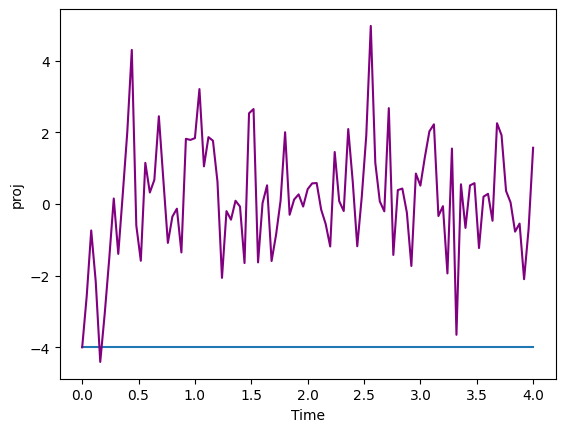

In [5]:
gen_sys_param()
n_qdrift_steps = 100
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,Heisenberg_d,Heisenberg_c,Heisenberg[0],t_max,n_qdrift_steps,t)
drift_time_evolution.Drift_exp()
trotter_time_evolution_cheat = AlgorithmHamSimTrotter(initial_state_circ,Heisenberg[0],measurements,t_max,n_qdrift_steps,t)
trotter_time_evolution_cheat._trotter_step_cheat(exps='Energy')
drift_time_evolution.execute(list(trotter_time_evolution_cheat._real_measurement.values()), color='purple')

In [4]:
gen_sys_param()
error = 1
n_qdrift_steps = 3
while error > 1e-4:
    U_sims = []
    gen_sys_param()
    time_evolution = AlgorithmHamSimqDrift(initial_state_circ,Heisenberg_d,Heisenberg_c,Heisenberg[0],t_max,n_qdrift_steps,t)
    time_evolution.Drift_exp()
    U_sim = time_evolution.execute()
    U_sims.append(U_sim)
    trotter_time_evolution = AlgorithmHamSimTrotter(initial_state_circ,Heisenberg[0],measurements,t_max,n_qdrift_steps,t)
    U = trotter_time_evolution.execute(color='green', cheat=False, plot=False)
    error = calculate_error(U_sims, U)
    print('step:',n_qdrift_steps,'error:',error)
    if error < precision:
        print('Congratulations!')
    n_qdrift_steps *= 10

step: 3 error: 1.8507102429864286
step: 30 error: 1.749055560834051
step: 300 error: 1.300882374374903
step: 3000 error: 0.7472272607324455
step: 30000 error: 0.1812082026023719
step: 300000 error: 0.059744391798576615


# Term grouping

In [19]:
import warnings
warnings.filterwarnings("ignore")
from openfermion import QubitOperator as q
from openfermion import get_sparse_operator
import scipy.sparse.linalg as ssl
import numpy as np
from itertools import permutations
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import Operator
from copy import copy, deepcopy
import networkx as nx
from networkx.algorithms.approximation import traveling_salesman_problem as tsp

In [28]:
input_Hamiltonian = '''
+ 0.003034656830204855 * IIIYYIIIYY 

+ 0.003034656830204855 * IIIXXIIIYY

+ 0.003034656830204855 * IIIYYIIIXX

+ 0.003034656830204855 * IIIXXIIIXX

- 0.008373361424264817 * YZZZYIIIYY

- 0.008373361424264817 * XZZZXIIIYY

- 0.008373361424264817 * YZZZYIIIXY

- 0.008373361424264817 * XZZZXIIIXX

+ 0.00211113766859809 * YZZYIIIIYY

+ 0.00211113766859809 * XZZXIIIIYY

+ 0.00211113766859809 * YZZYIIIIXX

+ 0.00211113766859809 * XZZXIIIIXX

- 0.00491756976241806 * IIIIIIIIYY

- 0.00491756976241806 * IIIIIIIIXX

+ 0.010540187409026488 * ZIIIIIIIYY
'''


In [13]:
def get_openfermion_str(pauli_term, reverse=False):
    
    cirq_term = []
    
    for i, op in enumerate(list(pauli_term)):
        if op == 'I':
            continue
        
        cirq_term.append(op + str(9-i if not reverse else i))
        
    new_pauli_term = ' '.join(cirq_term)
    
    return new_pauli_term

def ops_commute(op1, op2):
    sign = 1
    for pauli_1, pauli_2 in zip(list(op1), list(op2)):
        if pauli_1=='I' or pauli_2=='I' or pauli_1==pauli_2:
            continue
        sign *= -1
    
    return True if sign==1 else False

def ops_do_not_overlap(op_1, op_2):
    qbs = []
    for i, (p1, p2) in enumerate(zip(list(op_1), list(op_2))):
        # print(p1,p2)
        if p1!='I' and p2!='I':
            return False
    return True

def match_weight(op_1, op_2):
    weight = 0.
    for p1, p2 in zip(list(op_1), list(op_2)):
        if p1=='I' and p2=='I':
            continue
        elif p1=='I' or p2=='I':
            weight += 1.
        elif p1 == p2:
            weight += 0.
        else:
            weight += 2.
    return weight

# From https://stackoverflow.com/a/10824420
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            yield from flatten(i)
        else:
            yield i


In [16]:
import time
import sys
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import pprint
import copy
import networkx as nx
from networkx.algorithms import approximation

def prune_graph(G,nodes):
    for n in nodes:
        neighbors = G.pop(n)
        for nn in neighbors:
            G[nn].remove(n)


def degree_ordering(G):
    nodes = list(G.keys())
    return sorted(nodes, reverse=True, key=lambda n: len(G[n]))


def BronKerbosch_pivot(G,R,P,X,cliques):
    """
    For a given graph, G, find a maximal clique containing all of the vertices
    in R, some of the vertices in P, and none of the vertices in X.
    """
    if len(P) == 0 and len(X) == 0:
        # Termination case. If P and X are empty, R is a maximal clique
        cliques.append(R)
    else:
        # choose a pivot vertex
        pivot = next(iter(P.union(X)))
        # Recurse
        for v in P.difference(G[pivot]):
            # Recursion case. 
            BronKerbosch_pivot(G,R.union({v}),P.intersection(G[v]),
                               X.intersection(G[v]),cliques)
            P.remove(v)
            X.add(v)

def BronKerbosch(G):
    """
    Implementation of Bron-Kerbosch algorithm (Bron, Coen; Kerbosch, Joep (1973),
    "Algorithm 457: finding all cliques of an undirected graph", Commun. ACM,
    ACM, 16 (9): 575–577, doi:10.1145/362342.362367.) using a degree ordering
    of the vertices in G instead of a degeneracy ordering.
    See: https://en.wikipedia.org/wiki/Bron-Kerbosch_algorithm
    """

    max_cliques = []

    while len(G) > 0:
        P = set(G.keys())
        R = set()
        X = set()
        v = degree_ordering(G)[0]
        cliques = []
        BronKerbosch_pivot(G,R.union({v}),P.intersection(G[v]),
                           X.intersection(G[v]),cliques)

        #print('i = {}, current v = {}'.format(i,v))
        #print('# cliques: ',len(cliques))

        sorted_cliques = sorted(cliques, key=len, reverse=True)
        max_cliques += [sorted_cliques[0]]
        #print(sorted_cliques[0])

        prune_graph(G,sorted_cliques[0])

    return max_cliques

In [39]:
# Get ops and coeffs as list
split_input = input_Hamiltonian.split()
coeffs = []
ops = []
for i, term in enumerate(split_input):
    if '0' in term:
        coeff = float(term)
        sign = 1 if split_input[i-1]=='+' else -1
        coeffs.append(sign * coeff)
    elif term[0] in ['I','X','Y','Z']:
        ops.append(term)

# Dictionary with coeffs
ops_dict = {}
for coeff, op in zip(coeffs, ops):
    ops_dict[op] = coeff

# # Get ops in cirq format
# cirq_ops = []
# for op in ops:
#     cirq_ops.append(get_openfermion_str(op))

# # Get ops in cirq format, inverted
# cirq_ops_inv = []
# for op in ops:
#     cirq_ops_inv.append(get_openfermion_str(op, reverse=True))

#Using reduced coefficients
red_coeffs = []
red_ops = []
for coeff, op in zip(coeffs, ops):
    if abs(coeff) > 0.0035: #0.0035
        red_coeffs.append(coeff)
        red_ops.append(op)
# red_cirq_ops = []
# for op in red_ops:
#     red_cirq_ops.append(get_openfermion_str(op, reverse=True))
    
# red_H = q()
# for coeff, op in zip(red_coeffs, red_cirq_ops):
#     red_H += q(op, coeff)

# Terms associated with each coeff value
coeff_groups = {}
#for coeff, op in zip(coeffs, ops):
for coeff, op in zip(red_coeffs, red_ops):
    if coeff not in coeff_groups:
        coeff_groups[coeff] = [op]
    else:
        coeff_groups[coeff].append(op)
# print(coeff_groups)
# Check whether each set of terms for a coeff value has full commutativity
coeff_commuting_groups = {}
for coeff, op_list in coeff_groups.items():
    com = True
    for op1 in op_list:
        for op2 in op_list:
            com = com and ops_commute(op1, op2)
    coeff_commuting_groups[coeff] = com

# print(coeff_commuting_groups)
coeff_groups_sorted = dict(sorted(coeff_groups.items(), key = lambda x: -abs(x[0])))


In [34]:
sorted_ops = []
for coeff, op_list in coeff_groups_sorted.items():
    for op in op_list:
        sorted_ops.append(op)
# ops_no_I = deepcopy(sorted_ops)
# ops_no_I.remove('IIIIIIIIII')

# ops2 = ops_no_I

In [35]:
def final_order(min_clique_cover):
    """
    Takes a list of lists of commuting Pauli terms,
    and uses several procedures to minimize the depth
    count of the circuit.
    
    Parameters
    ----------
    min_clique_cover : list
        List of lists of mutually commuting terms.
        
    Returns
    -------
    list
        List of tuples `(op, qb)`, with `op` the Pauli
    term, and `qb` the qubit which should be used for 
    the `Rz` gate.
    """

    # For each set of commuting terms, rearrange 
    # the terms to parallelize evolutions that don't 
    # share qubits.
    # It does this by solving a minimum-clique-cover
    # problem, using the Bron-Kerbosh algorithm.
    min_overlap_cover = []
    for clique in min_clique_cover:
        overlap_dict = {}
        for op_1 in clique:
            comm_list = []
            for op_2 in clique:
                if op_1 == op_2:
                    continue   
                if ops_do_not_overlap(op_1, op_2):
                    comm_list.append(op_2)
            overlap_dict[op_1] = comm_list

        min_cover = BronKerbosch(overlap_dict)
        min_cover = [sorted(list(ov_clique), reverse=True) for ov_clique in min_cover]
        min_overlap_cover.append(min_cover)

    # Merge the parallel evolutions (temporarily),
    # and add a unique identifier to each term,
    # as some merged terms may be identical.
    min_target_cond = []
    for i, clique in enumerate(min_overlap_cover):
        min_target_cond.append([])
        for j, overlap in enumerate(clique):
            pauli = ['I' for _ in range(10)]
            for op in overlap:
                for p, pop in enumerate(list(op)):
                    if pop!='I':
                        pauli[p] = pop
            pauli = ''.join(pauli)
            min_target_cond[i].append((pauli, j))

    
    # Build the edges of a graph with the merged
    # terms as nodes, and the edge weights as the
    # similarity between the terms.
    # Solve a traveling-salesman-problem to find
    # the term order that minimizes Pauli gate 
    # differences between neighboring terms.
    # This part is inspired by the TSP portion of
    # 2001.05983, but the weight function is more
    # heuristic, as the paper's assumptions are 
    # not fully satisfied here.
    min_target_cond_ord = []
    for clique in min_target_cond:
        ops3 = clique
        if len(clique)==1:
            min_target_cond_ord.append(clique)
            continue
        edges = []
        for i, (op_1, label_1) in enumerate(ops3):
            for j, (op_2, label_2) in enumerate(ops3):
                if i == j:
                    continue
                edges.append(((op_1, label_1), (op_2, label_2), match_weight(op_1, op_2)))

        #print(ops3, edges)
        G = nx.Graph()
        G.add_nodes_from(ops3)
        G.add_weighted_edges_from(edges)

        min_target_cond_ord.append(tsp(G, cycle=False))

   
    # Unmerge the merged terms.
    min_target_cover_ord = []
    for i, clique in enumerate(min_target_cond_ord):
        min_target_cover_ord.append([])
        for op in clique:
            min_target_cover_ord[i].append(min_overlap_cover[i][op[1]])

    # We wish to choose, for each term, the qubit 
    # that is going to have the Rz gate in such a way
    # that the number of changes of that qubit from one
    # term to the next is minimized.
    # This allows us to maximize the CNOT cancellation 
    # potential.
    # This problem can be construed as a Set Cover problem;
    # here that problem is solved by using a greedy algorithm.
    # For terms that are run in parallel, we consider the merged
    # term. This means that, after unmerging, some terms will 
    # suboptimal qubit choices for the Rz gate. Nonetheless,
    # since our Hamiltonian is not highly parallelizable, we
    # expect this problem to have a negligible impact.
    target_list = [item for items in min_target_cond_ord for item in items]
    covering_sets = []
    set_names = []
    tmp_list = [list(op) for op, pos in target_list]
    for qb in range(10):
        #covering_sets.append([])
        qb_list = []
        qb_count = 0
        for i, op in enumerate(tmp_list):
            if op[qb] != 'I':
                qb_list.append(i)
            elif len(qb_list)!=0:
                covering_sets.append(qb_list)
                set_names.append((9-qb, qb_count))
                qb_count += 1
                qb_list = []
        if len(qb_list)!=0:
            covering_sets.append(qb_list)
            set_names.append((9-qb, qb_count))
            qb_count += 1
            qb_list = []

    # Set cover problem
    to_cover = set(range(len(target_list)))
    sets_available = [(i, set(row)) for i, row in enumerate(covering_sets)]
    sets_to_use = []
    while len(to_cover) > 0:
        max_val = -1
        argmax = -1
        for ind, (i, row) in enumerate(sets_available):
            val = len(to_cover & row)
            if val > max_val:
                max_val = val
                argmax = i
                argind = ind

        row_max = sets_available.pop(argind)
        sets_to_use.append(argmax)
        to_cover = to_cover ^ (to_cover & row_max[1])

    covering_sets_to_use = [covering_sets[i] for i in sets_to_use]
    set_names_to_use = [set_names[i] for i in sets_to_use]

    target_dict = {}
    for i, row in enumerate(covering_sets_to_use):
        for ind in row:
            target_dict[ind] = set_names_to_use[i][0]

    flat_cover_ord = [item for items in min_target_cover_ord for item in items]

    ops_w_targets = []
    for ind, col in enumerate(flat_cover_ord):
        ops_w_targets.append([])
        for op in col:
            ops_w_targets[-1].append((op, target_dict[ind]))

    # We finally flatten the list, to implement the circuit.
    flat_list = [item for items in ops_w_targets for item in items]

    return flat_list

def pauli_circuit(op, coeff, cnot='star', t=1.):
    """
    Implements the evolution of a Pauli term.
    
    Parameters
    ----------
    op : str, tuple
        The Pauli term to be implement (in Qiskit format). If
    tuple, the first entry contains the Pauli term, and the 
    second contains the qubit index where the Rz rotation should
    be applied.
    coeff : float
        The associated coefficient.
    cnot : {'star','ladder','parallel'}
        How to implement the CNOTs. The `star` and `ladder`
    methods are those known in the literature. The `parallel`
    method implements the `n` CNOTs using `log_2(n)` depth.
    t : float
        Evolution time.
        
    Returns
    -------
    QuantumCircuit
        Quantum circuit.
        
    Notes
    -----
    The `parallel` method results in lower depth circuits at the 
    outset, but the pyZX and transpile optimizations reduce the 
    `star` method more extensively, so it results in the circuits 
    with a lower depth than `parallel` by about 1%, on average.
    The `ladder` method is not competitive, depth-wise.
    
    Warnings
    --------
    The `parallel` method has a unknown bug, which occasionally
    causes to wrongly implement the CNOTs.
    """
    
    if isinstance(op, tuple):
        target_qb = op[1]
        op = op[0]
    else:
        target_qb = -1
    
    qc = QuantumCircuit(10)
    qc_cx = QuantumCircuit(10)
    non_I_qbs = []
    
    # Basis change
    for i, pauli in enumerate(reversed(list(op))):
        if pauli == 'Z':
            non_I_qbs.append(i)
        elif pauli == 'X':
            qc_cx.h(i)
            non_I_qbs.append(i)
        elif pauli == 'Y':
            qc_cx.sdg(i)
            qc_cx.h(i)
            non_I_qbs.append(i)
    
    # Identity case
    if len(non_I_qbs) == 0:
        return qc
    
    # CNOT gates
    if target_qb == -1:
        control_qbs = list(reversed(non_I_qbs[1:]))
        target = non_I_qbs[0]
    else:
        try:
            pos = non_I_qbs.index(target_qb)
        except ValueError:
            pos = 0
        control_qbs = list(reversed(non_I_qbs[:pos]+non_I_qbs[pos+1:]))
        target = non_I_qbs[pos]
    
    if cnot=='star':
        for qb in control_qbs:
            qc_cx.cx(qb, target)
    elif cnot=='ladder':
        for i in range(len(control_qbs)):
            if i == len(control_qbs)-1:
                qc_cx.cx(control_qbs[i], target)
            else:
                qc_cx.cx(control_qbs[i], control_qbs[i+1])
    elif cnot=='parallel':
        remaining_qbs = list(reversed(non_I_qbs))
        remaining_qbs.remove(target)
        remaining_qbs += [target]
        while len(remaining_qbs) > 1:
            targets = remaining_qbs[1::2]
            controls = remaining_qbs[0::2]
            #print(remaining_qbs, controls, targets)
            for i in range(len(targets)):
                qc_cx.cx(controls[i], targets[i])
            remaining_qbs = targets + ([controls[-1]] if len(remaining_qbs)%2==1 else [])
        
    qc += qc_cx
    qc.rz(2*coeff*t, target)
    qc += qc_cx.inverse()
            
    return qc

In [40]:
# We start by implementing the first step of 2001.05983,
# which solves a minimum-clique-cover problem to find
# a term grouping such that each group's terms mutually
# commute, and the number of terms is minimized.
# This is solved by using the Bron-Kerbosh algorithm.

comm_dict = {}
for op_1 in sorted_ops:
    comm_list = []
    for op_2 in sorted_ops:
        if op_1 == op_2:
            continue   
        if ops_commute(op_1, op_2):
            comm_list.append(op_2)
    comm_dict[op_1] = comm_list

min_clique_cover_orig = BronKerbosch(comm_dict)
# We reorder the terms within each group, we try to keep the performance
# near the original sorted order, which we already low has low error.

min_clique_cover = []
for clique in min_clique_cover_orig:
    lclique = list(clique)
    min_clique_cover.append(lclique)

min_clique_cover = [sorted(clique, key=lambda op: abs(ops_dict[op]), reverse=True) for clique in min_clique_cover]
# Get optimal ordering
flat_list = final_order(min_clique_cover)

# # Implement circuit
# circ = QuantumCircuit(10)
# for op in flat_list:
#     circ += pauli_circuit(op, ops_dict[op[0]], cnot='star', t=1.)